# KNN Classification Tutorial: Predicting Student Performance

**Dataset:** UCI Student Performance (Portuguese language class)

In this tutorial, you'll build a K-Nearest Neighbors (KNN) classifier to predict whether a student will pass or fail based on various features.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:

# URL of the raw student-mat.csv file
url = 'https://raw.githubusercontent.com/KunjalJethwani/StudentPerformance/main/student-por.csv'

# Load the dataset into a pandas DataFrame
df = pd.read_csv(url, sep=';')


## Exploratory Data Analysis (EDA)

Before diving into modeling, let's understand the data a bit more. We will:
- Check for any missing values.
- Look at basic statistics of numeric features.
- Examine the distribution of the target variable (which we will derive as pass/fail from the final grade G3).

In [3]:
# Check for missing values
print(df.isnull().sum())

# Summary statistics
print(df.describe())

print("Dataset shape:", df.shape)
df.head()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64
              age        Medu        Fedu  traveltime   studytime    failures  \
count  649.000000  649.000000  649.000000  649.000000  649.000000  649.000000   
mean    16.744222    2.514638    2.306626    1.568567    1.930663    0.221880   
std      1.218138    1.134552    1.099931    0.748660    0.829510    0.593235   
min     15.000000    0.000000    0.000000    1.000000    1.000000    0.000000   
25%     16.000000    2.000000    1.000000    1.000000 

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


We also want to determine our target. The final grade G3 is a number from 0 to 20. We can define “pass” as having a final grade ≥ 10 (this is a common passing cutoff in this grading system, meaning 50% or higher). Let’s create a new binary column Pass that is 1 if G3 >= 10 and 0 if G3 < 10, and see the distribution.

In [4]:
# Create binary target column
df['Pass'] = (df['G3'] >= 10).astype(int)

# Target distribution
print(df['Pass'].value_counts())
print(df['Pass'].value_counts(normalize=True) * 100)

Pass
1    549
0    100
Name: count, dtype: int64
Pass
1    84.59168
0    15.40832
Name: proportion, dtype: float64


Let's also do a quick check of some features:
- For instance, what's the average study time or absences for those who passed vs those who failed?

In [5]:
# Compare average study time and absences between passed vs failed
print(df.groupby('Pass')['studytime'].mean())
print(df.groupby('Pass')['absences'].mean())

Pass
0    1.610000
1    1.989071
Name: studytime, dtype: float64
Pass
0    4.610000
1    3.486339
Name: absences, dtype: float64


### Reflection Questions - Understanding the Data
1. Which features seem most predictive of whether a student will pass or fail? Why?
  - G1, G2, G3: performance is often a good indicator
2. Are there other exploration methods we could use to determine predictive variables?
   - Correlation analysia to calculate correlation coefficients to quantify the strength and direction of relationships between numerical features and the target
3. Are there any features you would consider removing? Why?
  - Features like sex or address might introduce bias
4. Do you notice any imbalance in the pass/fail outcome? How might this affect model performance?
  - Maybe. If one class (pass or fail) has significantly more samples than the other, it's an imbalanced dataset.

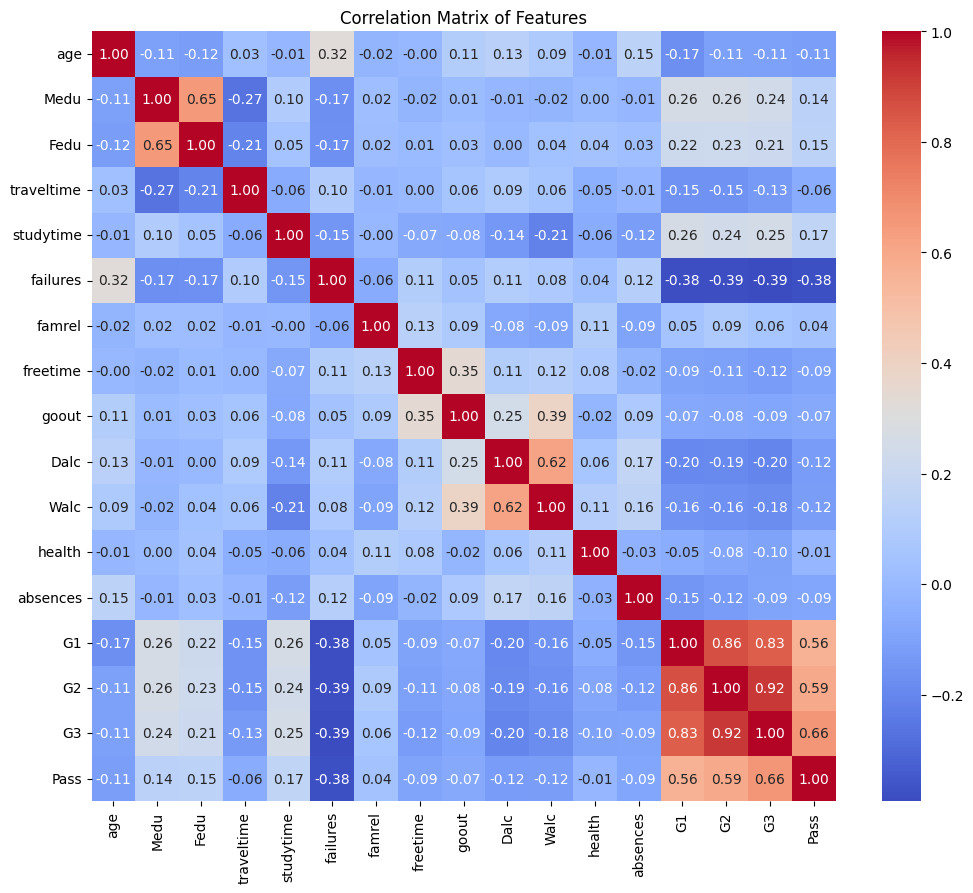

In [19]:
numeric_features = df.select_dtypes(include=np.number)

correlation_matrix = numeric_features.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

## Preprocessing

Now we prepare the data for the KNN algorithm. KNN works with numeric feature vectors and a distance metric. Our dataset has many categorical features (like school, sex, etc.), so we need to convert them to numeric form (encoding). Also, we will scale the features to ensure fair distance calculations.

Steps in preprocessing:

1.	Drop columns that won't be used as features. For example, G1 and G2 (first and second period grades) are actually prior grades. To simulate predicting final result from other factors early, we will exclude G1 and G2 from features. We also exclude G3 itself (since that's the final grade and forms our target, not a feature).

2.	Encode binary categorical variables (e.g., no/yes, M/F, etc.) as 0/1.

3.	One-hot encode multi-category variables (like Mjob, Fjob which have multiple categories such as "teacher", "health", etc.).

4.	Scale the features using standardization (zero mean, unit variance).


In [6]:
# Drop the grade columns we aren't using as features
X = df.drop(columns=['G1', 'G2', 'G3', 'Pass'])  # feature set
y = df['Pass']  # target variable
print("Features remaining:", X.columns.tolist())

Features remaining: ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


In [7]:

# Map binary categorical features
binary_mappings = {
    'school': {'GP': 0, 'MS': 1},
    'sex': {'M': 0, 'F': 1},
    'address': {'U': 1, 'R': 0},
    'famsize': {'LE3': 0, 'GT3': 1},  # LE3 = family size <=3, GT3 = >3
    'Pstatus': {'T': 1, 'A': 0},      # T = together (parents), A = apart
    'schoolsup': {'yes': 1, 'no': 0},
    'famsup': {'yes': 1, 'no': 0},
    'paid': {'yes': 1, 'no': 0},
    'activities': {'yes': 1, 'no': 0},
    'nursery': {'yes': 1, 'no': 0},
    'higher': {'yes': 1, 'no': 0},
    'internet': {'yes': 1, 'no': 0},
    'romantic': {'yes': 1, 'no': 0}
}


# Apply the mappings
for col, mapping in binary_mappings.items():
    X[col] = X[col].map(mapping)

# Verify a couple of columns were encoded (e.g., sex, schoolsup)
print(X[['sex', 'schoolsup']].head(5))

   sex  schoolsup
0    1          1
1    1          0
2    1          1
3    1          0
4    1          0


In [8]:
# One-hot encode multi-category features
X = pd.get_dummies(X, columns=['Mjob', 'Fjob', 'reason', 'guardian'], drop_first=True)
print("Features after one-hot encoding:", X.columns.tolist())
print("Total number of features now:", X.shape[1])

Features after one-hot encoding: ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_mother', 'guardian_other']
Total number of features now: 39


In [9]:

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])


Train size: 519 Test size: 130


**Explanation**: We use stratify=y to ensure the train/test split maintains the proportion of pass/fail similar to the original (so we don't happen to get, say, all fails in test by random chance). The random_state ensures reproducibility.

After this, suppose we have ~519 training samples and 130 testing (since 20% of 649 is about 130).

In [10]:

# Initialize a scaler and fit on training data
scaler = StandardScaler()
scaler.fit(X_train)

# Transform both training and testing data
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)


## Training a KNN Classifier

With data prepared, we can now train the K-Nearest Neighbors classifier. Let's start with an initial guess for K (say, K=5) and Euclidean distance (the default).

In [11]:
from sklearn.neighbors import KNeighborsClassifier

# Instantiate KNN with k=5
knn = KNeighborsClassifier(n_neighbors=5)

# Train (fit) the classifier on the training data
knn.fit(X_train_scaled, y_train)

# Evaluate on the training set and test set
train_acc = knn.score(X_train_scaled, y_train)
test_acc = knn.score(X_test_scaled, y_test)
print(f"K=5 Train Accuracy: {train_acc:.3f}, Test Accuracy: {test_acc:.3f}")

K=5 Train Accuracy: 0.879, Test Accuracy: 0.777


**Explanation**: The `.score` method for classifiers in scikit-learn returns accuracy by default. We check both train and test accuracy for K=5. If training accuracy is much higher than test accuracy, that might indicate overfitting. If both are reasonably close, that's a good sign.

For example, we might see something like:
- K=5 Train Accuracy: 0.82 (82%), Test Accuracy: 0.75 (75%).
This would indicate the model does fairly well and isn't severely overfitting (some gap is expected because the model should perform a bit better on data it has seen).

However, we chose K=5 arbitrarily. Let's use cross-validation to confirm if K=5 is indeed a good choice or if we should adjust K.


## Choosing the Best K with Cross-Validation

We can now perform a simple cross-validation on the training set for different values of K to see which gives the highest validation accuracy. Let's try K = 1 through 15.

In [12]:
from sklearn.model_selection import cross_val_score

# Try K from 1 to 15 and record cross-validation accuracy (using 5-fold CV)
cv_scores = []
neighbors = range(1, 16)
for k in neighbors:
    knn_k = KNeighborsClassifier(n_neighbors=k)
    # 5-fold cross-validation on training data
    scores = cross_val_score(knn_k, X_train_scaled, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Print the scores
for k, acc in zip(neighbors, cv_scores):
    print(f"K={k}, Mean CV Accuracy={acc:.3f}")

K=1, Mean CV Accuracy=0.827
K=2, Mean CV Accuracy=0.798
K=3, Mean CV Accuracy=0.832
K=4, Mean CV Accuracy=0.823
K=5, Mean CV Accuracy=0.840
K=6, Mean CV Accuracy=0.844
K=7, Mean CV Accuracy=0.852
K=8, Mean CV Accuracy=0.850
K=9, Mean CV Accuracy=0.848
K=10, Mean CV Accuracy=0.855
K=11, Mean CV Accuracy=0.852
K=12, Mean CV Accuracy=0.852
K=13, Mean CV Accuracy=0.850
K=14, Mean CV Accuracy=0.844
K=15, Mean CV Accuracy=0.852


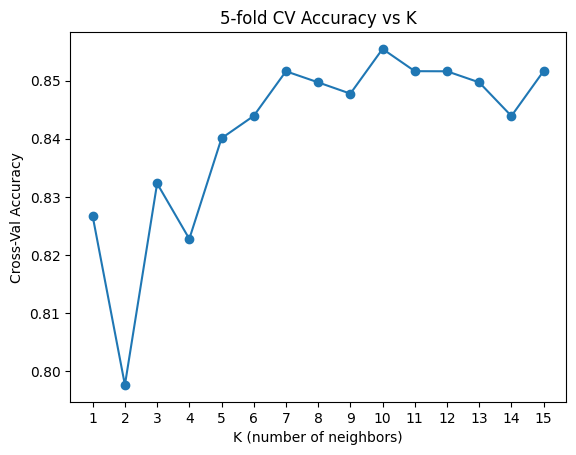

In [13]:

plt.plot(neighbors, cv_scores, marker='o')
plt.xlabel('K (number of neighbors)')
plt.ylabel('Cross-Val Accuracy')
plt.title('5-fold CV Accuracy vs K')
plt.xticks(range(1,16))
plt.show()


### Reflection Questions – Model Complexity and Tuning
1. How did model performance change as K increased?
  - Overall, the model's performance tended to improve with increasing K, up to a certain point where it stabilized or started to slightly decline.
2. What value of K gave the best validation accuracy?
    - K=10 appears to be the optimal choice for this model based on the validation results.
3. How might your choice of K differ if recall for the 'fail' class were more important?
(SKIP)

## Final Evaluation with Best K

In [14]:
# Retrain KNN with the best K (here assuming 5 was best)
best_k = 10
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train_scaled, y_train)

# Evaluate on test set
y_pred = knn_best.predict(X_test_scaled)
test_acc = knn_best.score(X_test_scaled, y_test)
print(f"Best K = {best_k}, Test Accuracy = {test_acc:.3f}")

Best K = 10, Test Accuracy = 0.823


## Evaluation Metrics

In [15]:
from sklearn.metrics import confusion_matrix, classification_report

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Classification report (precision, recall, f1)
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=["Fail", "Pass"]))

Confusion Matrix:
 [[  2  18]
 [  5 105]]
Classification Report:
               precision    recall  f1-score   support

        Fail       0.29      0.10      0.15        20
        Pass       0.85      0.95      0.90       110

    accuracy                           0.82       130
   macro avg       0.57      0.53      0.52       130
weighted avg       0.77      0.82      0.79       130



**Interpretation**

- Green circle with black outline = False Negative (actually pass, predicted fail)
- Red circle with black outline = False Positive (actually fail, predicted pass)

**Reflection Questions**

1. What is the strongest metric of this model shown above?
  - The strongest metric appears to be the precision for the 'Pass' class (0.85) and the recall for the 'Pass' class (0.95). This means the model is very good at correctly identifying students who will pass and most of the students it predicts to pass do indeed pass
2. What is the weakest metric?
  - The weakest metric is the recall and precision for the 'Fail' class (0.10 and 0.29 respectively). This indicates that the model struggles to correctly identify students who will fail.
3. What sort of mistakes is the model making? Why do you think this is?
  - The model is primarily making false negative errors - predicting "Pass" when the actual outcome is "Fail"

### ROC and AUC

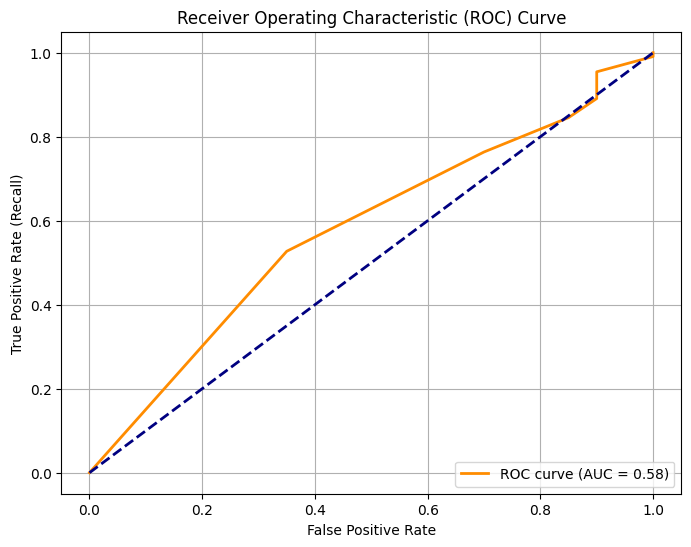

In [16]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class (Pass = 1)
y_probs = knn_best.predict_proba(X_test_scaled)[:, 1]  # column 1 is prob for class 1

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # random baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

### Reflection Questions – Interpreting Model Performance
1. What does the ROC curve tell you about model performance?
  - The AUC is 0.58, which is only slightly better than random guessing (AUC = 0.5). This suggests that the model has poor discriminative power.
2. How do accuracy, precision, recall, and AUC complement each other?
  - Accuracy measures the proportion of correctly classified instances but can be misleading if classes are imbalanced.
  - Precision indicates how many predicted positives are actually correct, which is crucial when false positives are costly.
  - Recall  shows how well the model captures actual positives, which is important in high-risk scenarios.
  - AUC helps assess the model’s ability to distinguish between classes regardless of the decision threshold.
3. Based on your results, would you recommend this model for identifying students at risk of failing?
  - Given the low AUC (0.58), the model is not very reliable at distinguishing students at risk of failing from those who are not.

## Next Steps (Optional)
- Try using `weights='distance'` in the KNN model.
- Compare KNN with Logistic Regression on this dataset.
- Try dimensionality reduction (e.g., PCA) before applying KNN.
- Explore different distance metrics like Manhattan or Hamming.

## KNN From Scratch

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# =============================
# Define Custom KNN Classifier
# =============================

class KNNClassifierScratch:
    def __init__(self, k=5):
        """
        Initialize the custom KNN classifier.

        Parameters:
            k (int): Number of nearest neighbors to consider.
        """
        self.k = k
        self.X_train = None  # Placeholder for training feature data
        self.y_train = None  # Placeholder for training labels

    def fit(self, X, y):
        """
        Fit the model using the training data.

        Since KNN is a lazy learner, fitting simply stores the data.

        Parameters:
            X (numpy.ndarray): 2D array of training data (n_samples x n_features).
            y (numpy.ndarray): 1D array of training labels.
        """
        self.X_train = X
        self.y_train = y

    def _euclidean_distance(self, a, b):
        """
        Compute the Euclidean distance between two vectors a and b.

        Parameters:
            a (numpy.ndarray): 1D array representing one point.
            b (numpy.ndarray): 1D array representing another point.

        Returns:
            float: Euclidean distance.
        """
        return np.sqrt(np.sum((a - b) ** 2))

    def predict(self, X):
        """
        Predict the class labels for the input samples X.

        For each test sample, calculate its distance to all training samples,
        select the k closest ones, and choose the most frequent label.

        Parameters:
            X (numpy.ndarray): 2D array of test samples (n_test_samples x n_features).

        Returns:
            numpy.ndarray: 1D array of predicted class labels.
        """
        predictions = []  # To store predictions for each test sample

        # Loop over each test point
        for test_point in X:
            # Compute distances between test_point and every training point
            distances = np.array([self._euclidean_distance(test_point, x_train)
                                  for x_train in self.X_train])

            # Get the indices of the k smallest distances
            nearest_indices = np.argsort(distances)[:self.k]

            # Retrieve the labels of these nearest neighbors
            nearest_labels = self.y_train[nearest_indices]

            # Use majority vote to determine the predicted label
            predicted_label = Counter(nearest_labels).most_common(1)[0][0]
            predictions.append(predicted_label)

        return np.array(predictions)

# =============================
# Generate Synthetic Data
# =============================

# Create a synthetic binary classification dataset
X, y = make_classification(n_samples=200, n_features=5, n_redundant=0,
                           n_clusters_per_class=1, class_sep=1.0, random_state=42)

# Split the dataset into 80% training and 20% testing (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# =============================
# Train and Evaluate Custom KNN
# =============================

# Instantiate our custom KNN with k=5
knn_custom = KNNClassifierScratch(k=5)
# Fit the model (simply stores the training data)
knn_custom.fit(X_train, y_train)
# Predict class labels on the test set
predictions_custom = knn_custom.predict(X_test)
# Compute accuracy of the custom KNN
accuracy_custom = accuracy_score(y_test, predictions_custom)

# =============================
# Train and Evaluate sklearn KNN
# =============================

# Instantiate scikit-learn's KNeighborsClassifier with k=5
knn_sklearn = KNeighborsClassifier(n_neighbors=5)
# Fit the model using training data
knn_sklearn.fit(X_train, y_train)
# Predict class labels on the test set
predictions_sklearn = knn_sklearn.predict(X_test)
# Compute accuracy of the sklearn KNN
accuracy_sklearn = accuracy_score(y_test, predictions_sklearn)

# =============================
# Compare the Predictions & Accuracy
# =============================

print("Custom KNN predictions:")
print(predictions_custom)
print("sklearn KNN predictions:")
print(predictions_sklearn)
print()
print(f"Custom KNN Accuracy: {accuracy_custom * 100:.2f}%")
print(f"sklearn KNN Accuracy: {accuracy_sklearn * 100:.2f}%")

Custom KNN predictions:
[0 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0 1 1 1 1 0 1 0 1 0 0 1 0
 0 1 0]
sklearn KNN predictions:
[0 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0 1 1 1 1 0 1 0 1 0 0 1 0
 0 1 0]

Custom KNN Accuracy: 82.50%
sklearn KNN Accuracy: 82.50%
